# Visualize the mean power in band for a few observations. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import pandas as pd
from joblib import Memory
import re
%matplotlib inline

## Make a dataframe of file meta data

In [2]:
def pathToSeries(path):
    if 'train' in path: train = 1
    else: train = 0
    if train: 
        m = re.search('(\d).mat',path)
        preictal = int(m.group(1))
    else: preictal = -1
    m = re.search('(\d)/',path)
    patient = int(m.group(1))
    m = re.search('(.*)/(.*)',path)
    dir_name = m.group(1)
    file_name = m.group(2)
    return pd.Series({'path':path,'train':train,'preictal':preictal, 'patient':patient,
                     'dir_name': dir_name,'file_name':file_name})

base_data_dir = '../raw_data'
data_dirs = [name for name in os.listdir(base_data_dir) if os.path.isdir(os.path.join(base_data_dir, name))]
paths = [[os.path.join(data_dir, name) for name in os.listdir(os.path.join(base_data_dir,data_dir))] 
         for data_dir in data_dirs] 
paths = [j for i in paths for j in i] # flatten to 1d
paths = [i for i in paths if '.DS_Store' not in i]

files_df = pd.DataFrame([pathToSeries(p) for p in paths])
files_df['file_id'] = np.arange(0,files_df.shape[0])
files_df.head(5)

,dir_name,file_name,path,patient,preictal,train,file_id
0,test_1,1_1.mat,test_1/1_1.mat,1,-1,0,0
1,test_1,1_10.mat,test_1/1_10.mat,1,-1,0,1
2,test_1,1_100.mat,test_1/1_100.mat,1,-1,0,2
3,test_1,1_1000.mat,test_1/1_1000.mat,1,-1,0,3
4,test_1,1_1001.mat,test_1/1_1001.mat,1,-1,0,4


## Accessing the data

In [3]:
def matToArr(path):
    try: 
        mat = loadmat(path)
        return mat['dataStruct']['data'][0][0].transpose()
    except:
        return np.empty(0)

In [90]:
def getPath(patient,train,preictal,sample):
    path = files_df[(files_df.patient==patient) &
                   (files_df.train==train) &
                   (files_df.preictal==preictal)
                   ].iloc[sample]['path']
    return os.path.join(base_data_dir,path)

interictal_example = matToArr(getPath(1,1,0,0)) 
preictal_example =  matToArr(getPath(1,1,1,0)) 
test_example =  matToArr(getPath(1,0,-1,0)) 
print(interictal_example.shape)

(16, 240000)


## Compute power spectrum for each file and save

In [113]:
SAMPLING_RATE = 400 # Hz

def calculate_fft(path):
    samples = matToArr(path)
    if samples.size == 0: return np.empty(0), np.empty(0)
    n = samples.shape[1]
    freq = np.array(np.fft.fftfreq(n)*SAMPLING_RATE)[:n//2]
    power = np.abs(np.fft.fft(samples))[:,:n//2]
    return freq,power
                   
def bin_power(freq, power):
    max_power = np.max(power)
    if max_power == 0: max_power = 1 # avoids divide by zero error if all data missing
    norm_power = power/max_power
    pib = []
    for i in np.arange(bands.size-1):
        band_1 = bands[i]
        band_2 = bands[i+1]
        freq_inds = np.where((freq >= band_1) & (freq <= band_2)) # calculate bin indices for bands 1 and 2
        power_in_band = norm_power[:,freq_inds]
        avg_power_in_band = power_in_band.mean()
        pib.append(avg_power_in_band)
    return pib

def extract_pib_features(path,bands):
    freq, power = calculate_fft(path)
    if power.size == 0: return np.array([-1]*(bands.size-2))
    pib = bin_power(freq,power)
    return pib[:-1]

pibs = []
bands = np.array([0.1, 4, 8, 12, 30, 70, 180]) # frequency bands in Hz
number_of_samples = 24
interictal_features = np.zeros((number_of_samples, bands.size-2))
preictal_features = np.zeros((number_of_samples, bands.size-2))
for i, row in files_df[0:num_samples].iterrows():
    print(str(i)+" ",end="")
    interictal_features[i,:] = extract_pib_features(getPath(1,1,0,i),bands)
    preictal_features[i,:] = extract_pib_features(getPath(1,1,1,i),bands)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 

## Read in saved data to make sure saved correctly.

## Visualize results

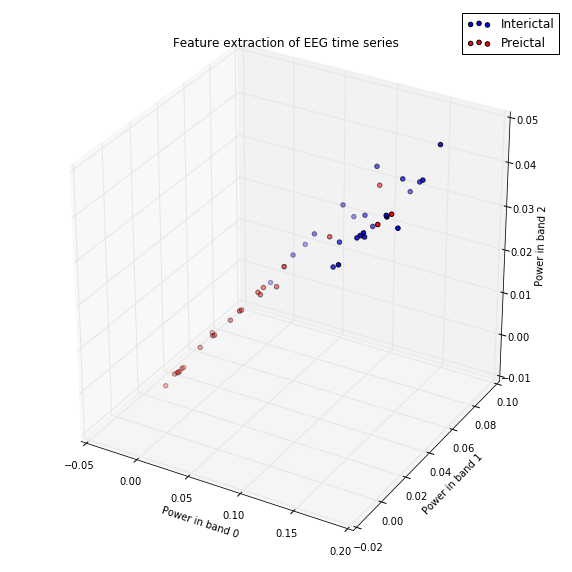

In [114]:
bins_to_plot = [0,1,2]

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(interictal_features[:,bins_to_plot[0]],
           interictal_features[:,bins_to_plot[1]],
           interictal_features[:,bins_to_plot[2]], c='blue', label='Interictal')
ax.scatter(preictal_features[:,bins_to_plot[0]],
           preictal_features[:,bins_to_plot[1]],
           preictal_features[:,bins_to_plot[2]], c='red', label='Preictal')
ax.set_xlabel('Power in band ' + str(bins_to_plot[0]))
ax.set_ylabel('Power in band ' + str(bins_to_plot[1]))
ax.set_zlabel('Power in band ' + str(bins_to_plot[2]))
ax.set_title('Feature extraction of EEG time series')
ax.legend()
plt.show()